# MDETR
the code below is referenced from https://github.com/ashkamath/mdetr

In [2]:
! pip install timm==0.4.5 transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon


torch.set_grad_enabled(False);

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

## Detection

In this section, we show the performance of our pre-trained model on modulated detection. 
Keep in mind that this model wasn't fine-tuned for any specific task.

We load the model from torch hub

In [ ]:
model, postprocessor = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5', pretrained=True, return_postprocessor=True)
model = model.cuda()
model.eval();

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ashkamath/mdetr/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://zenodo.org/record/4721981/files/pretrained_EB5_checkpoint.pth" to /root/.cache/torch/hub/checkpoints/pretrained_EB5_checkpoint.pth
100%|██████████| 2.53G/2.53G [01:49<00:00, 24.7MB/s]


In [ ]:
def plot_inference(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  memory_cache = model(img, [caption], encode_and_save=True)
  outputs = model(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(im, probas[keep], bboxes_scaled, labels)

# Visualize Flickr30k
Next, we retrieve an image on which we wish to test the model. Here, we use a random set of images from the test set of Flickr30k dataset.

In [ ]:
import xml.etree.ElementTree as ET

def get_sentence_data(fn):
    """
    Parses a sentence file from the Flickr30K Entities dataset

    input:
      fn - full file path to the sentence file to parse
    
    output:
      a list of dictionaries for each sentence with the following fields:
          sentence - the original sentence
          phrases - a list of dictionaries for each phrase with the
                    following fields:
                      phrase - the text of the annotated phrase
                      first_word_index - the position of the first word of
                                         the phrase in the sentence
                      phrase_id - an identifier for this phrase
                      phrase_type - a list of the coarse categories this 
                                    phrase belongs to

    """
    with open(fn, 'r') as f:
        sentences = f.read().split('\n')

    annotations = []
    for sentence in sentences:
        if not sentence:
            continue

        first_word = []
        phrases = []
        phrase_id = []
        phrase_type = []
        words = []
        current_phrase = []
        add_to_phrase = False
        for token in sentence.split():
            if add_to_phrase:
                if token[-1] == ']':
                    add_to_phrase = False
                    token = token[:-1]
                    current_phrase.append(token)
                    phrases.append(' '.join(current_phrase))
                    current_phrase = []
                else:
                    current_phrase.append(token)

                words.append(token)
            else:
                if token[0] == '[':
                    add_to_phrase = True
                    first_word.append(len(words))
                    parts = token.split('/')
                    phrase_id.append(parts[1][3:])
                    phrase_type.append(parts[2:])
                else:
                    words.append(token)

        sentence_data = {'sentence' : ' '.join(words), 'phrases' : []}
        for index, phrase, p_id, p_type in zip(first_word, phrases, phrase_id, phrase_type):
            sentence_data['phrases'].append({'first_word_index' : index,
                                             'phrase' : phrase,
                                             'phrase_id' : p_id,
                                             'phrase_type' : p_type})

        annotations.append(sentence_data)

    return annotations

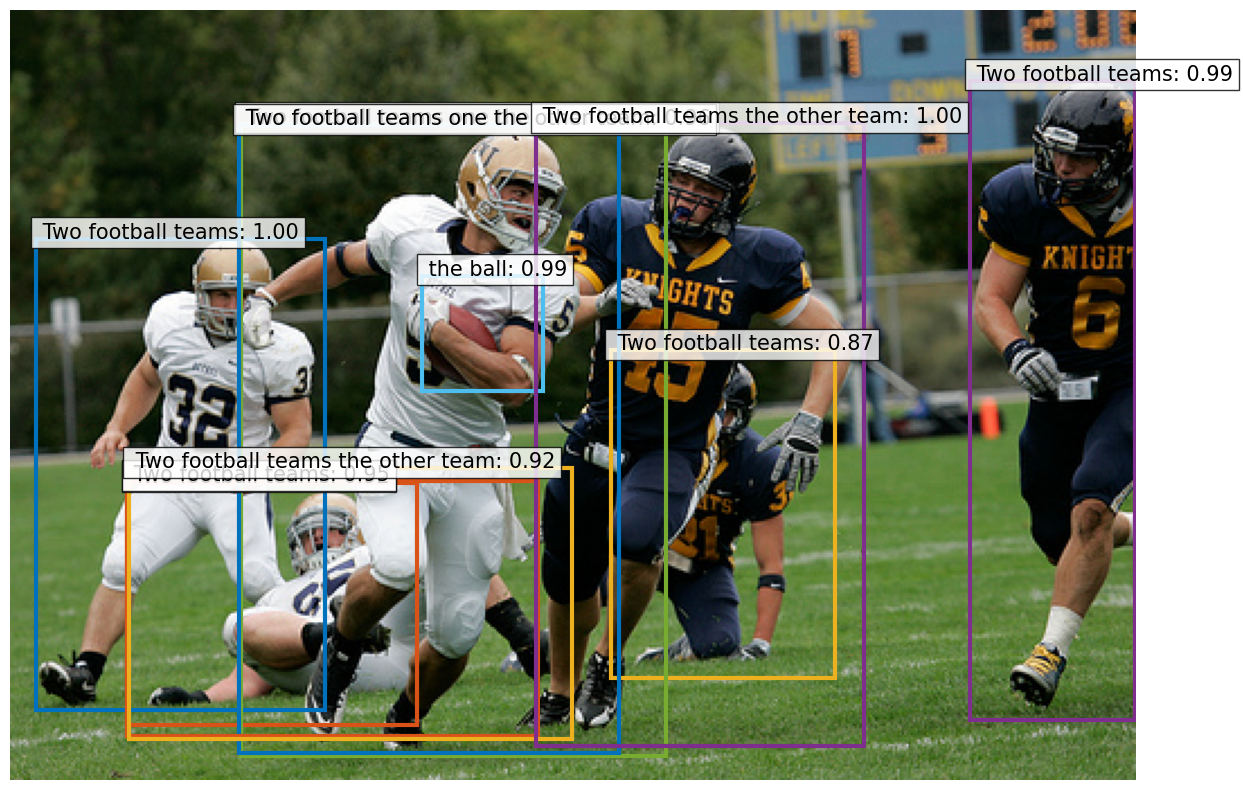

In [ ]:
# example
image_file="5009047021.jpg"
sentence_file="5009047021.txt"
image = Image.open(image_file)
sentences = get_sentence_data(sentence_file)
sentences = sentences[1]['sentence']
plot_inference(image, sentences)

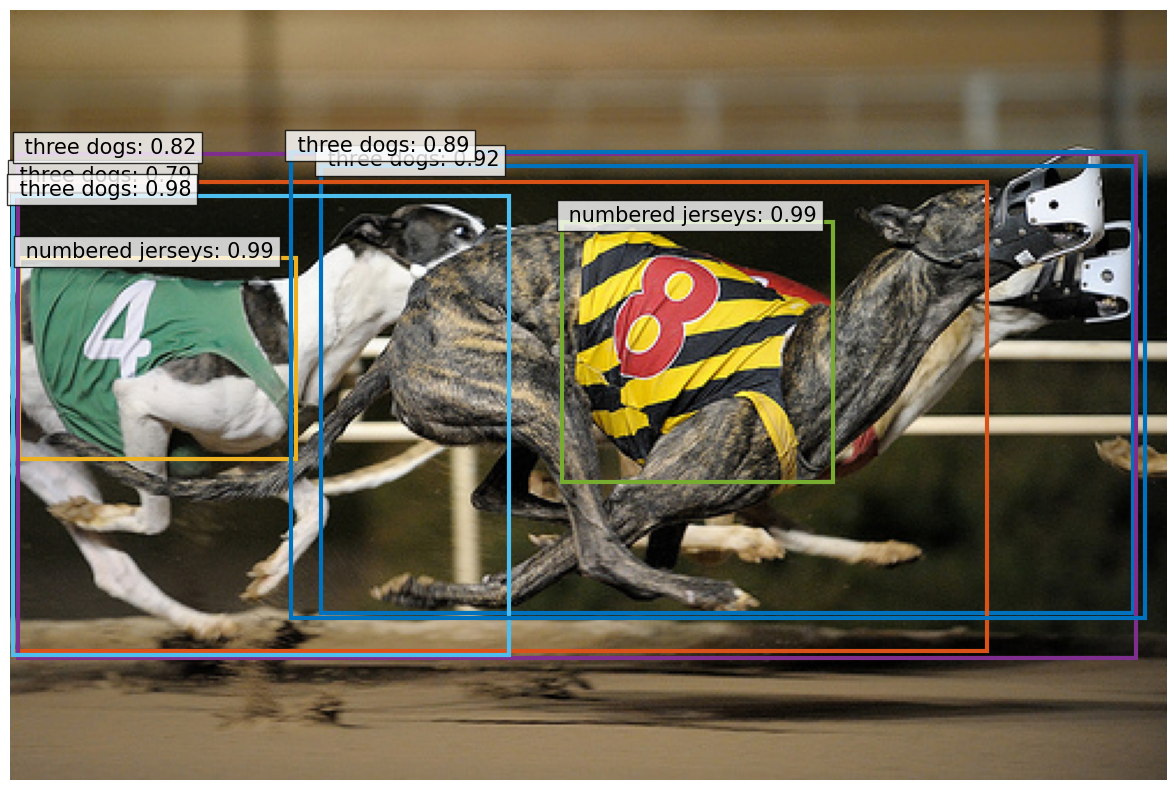

In [ ]:
image_file="3217187564.jpg"
sentence_file="3217187564.txt"
image = Image.open(image_file)
sentences = get_sentence_data(sentence_file)
sentences = sentences[1]['sentence']
plot_inference(image, sentences)

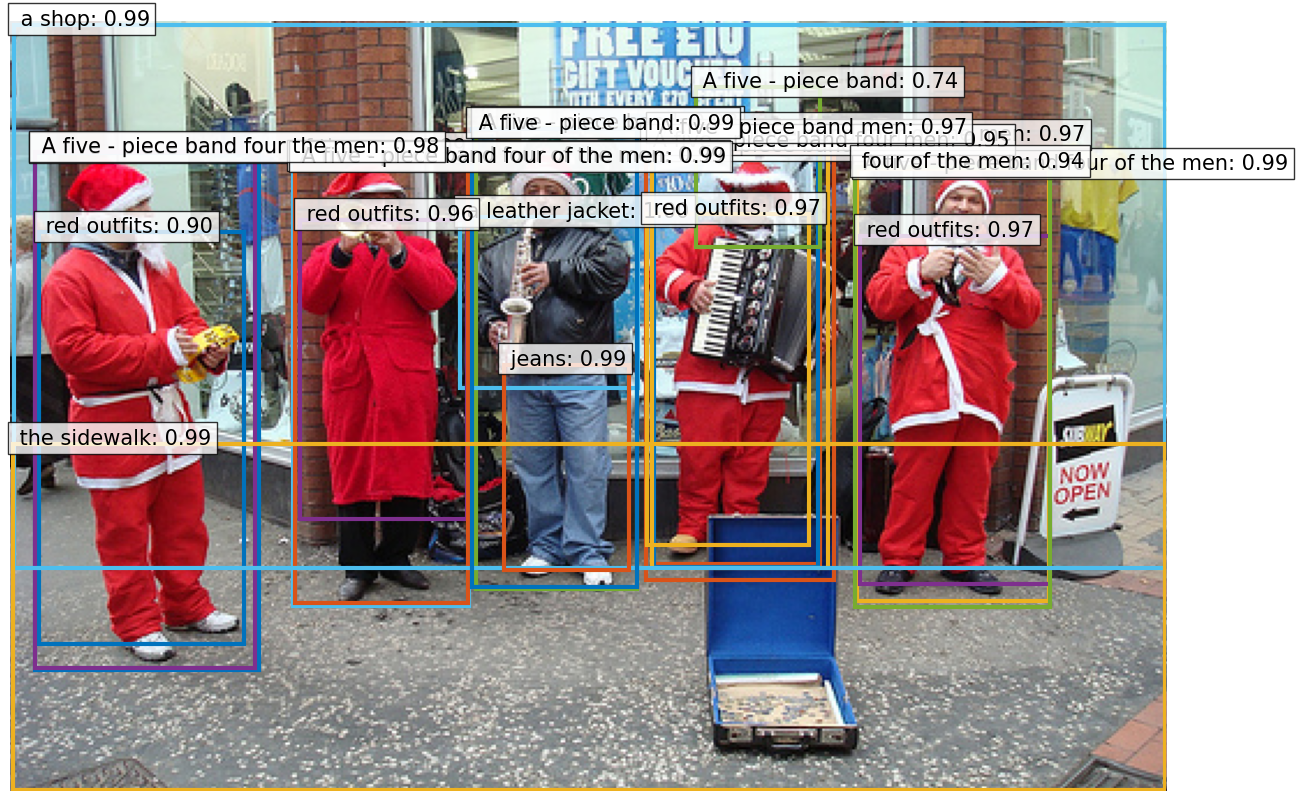

In [ ]:
image_file="2123838998.jpg"
sentence_file="2123838998.txt"
image = Image.open(image_file)
sentences = get_sentence_data(sentence_file)
sentences = sentences[1]['sentence']
plot_inference(image, sentences)

In [ ]:
# visualize the test folder

folder_path = "test"
output_folder = "output"

for filename in sorted(os.listdir(folder_path)):
    if filename.endswith('.txt'):
        sentence_file = os.path.join(folder_path, filename)
        sentences = get_sentence_data(sentence_file)
        sentences = sentences[0]['sentence']

        image_file = os.path.join(folder_path, filename.replace('.txt', '.jpg'))
        
        try:
            image = Image.open(image_file)
            plot_inference(image, sentences)
            output_path = os.path.join(output_folder, filename.replace('.txt', '.jpg'))
            print(f"successfully processed image: {image_file}")
            image.save(output_path)  # Save the image using PIL's save method
        except Exception as e:
            print(f"An error occurred for image: {image_file}")
            print(f"Error message: {str(e)}")
            continue


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# !rm -rf "output"

# Detection on Comics

1. frame extraction (page vs panel)
2. OCR

In [ ]:
# import library 
import os
import numpy as np
from PIL import Image, ImageDraw
import cv2
import shutil
import pandas as pd
import csv 
import re


In [ ]:
# set parameters

# Set the desired dimensions for the images
width = 1600
height = 2000

## Frame extraction 

In [ ]:
def preprocess_page(dir_path, width, height, output_dir):
  # Loop through all files in the input directory
  for filename in os.listdir(dir_path):
    # Get the full path of the file
    filepath = os.path.join(dir_path, filename)
    # Check if the file is an image
    if os.path.isfile(filepath) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
      # Load the image
      img = Image.open(filepath)
      # Resize the image to the desired dimensions
      img = img.resize((width, height))
      # Convert the image to grayscale
      img = img.convert('L')
      # Save the resized image to the output directory
      img.save(os.path.join(output_dir, filename))
  return output_dir

In [ ]:
def frame_extraction(input_dir, output_dir):
    
    # Loop through all images in the input directory
    for img_filename in os.listdir(input_dir):
        # Load the image
        img = cv2.imread(os.path.join(input_dir, img_filename))
        
        # Apply Canny edge detection
        edges = cv2.Canny(img, 50, 150, apertureSize=3)
        
        # Find contours in the edges image
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Loop over the contours and filter out the ones that are not frames
        frames = set()
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 700 and h > 800: # adjust the minimum width and height to filter out small contours
                aspect_ratio = float(w)/h
                if aspect_ratio > 0.3 and aspect_ratio < 3.0: # adjust the aspect ratio range to filter out non-frame contours
                    frame=(x, y, w, h)
                    if frame not in frames:
                        frames.add(frame)
                        
        # Crop the image to the bounding boxes to extract the frames
        for i, frame in enumerate(frames):
            x, y, w, h = frame
            frame_img = img[y:y+h, x:x+w]
            filename = f'{img_filename.split(".")[0]}_frame_{i}.jpg' # Add the image filename to the frame filename
            cv2.imwrite(os.path.join(output_dir, filename), frame_img)
            
    return output_dir


## OCR


In [ ]:
# installation 
!pip install paddlepaddle==2.4.1 -i https://pypi.tuna.tsinghua.edu.cn/simple
import paddle
paddle.utils.run_check()
!pip install "paddleocr>=2.0.1" 
!pip install nltk
from paddleocr import PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 23.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery 3.9.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0

Running verify PaddlePaddle program ... 
PaddlePaddle works well on 1 CPU.
PaddlePaddle works well on 2 CPUs.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.


/usr/local/lib/python3.10/dist-packages/paddle/fluid/executor.py:1583: UserWarning: Standalone executor is not used for data parallel
  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.9/445.9 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 115.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 106.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:14<00:00, 276kiB/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer/en_PP-OCRv3_rec_infer.tar


100%|██████████| 9.96M/9.96M [00:19<00:00, 498kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:15<00:00, 137kiB/s]

[2023/06/02 11:15:16] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='/usr/local

In [ ]:
def OCR (frame):
  frame = Image.open(frame)
  all_texts = []
  img_np = np.array(frame)
  text = ocr.ocr(img_np, cls=True)
  new_result=text[0]
  texts = [line[1][0] for line in new_result]
  all_texts.extend(texts)
  sentence=" ".join(all_texts)
  sentence = sentence.replace("'", '')
  return sentence

In [ ]:
import logging

# Disable debug messages from ppocr logger
logging.getLogger('ppocr').setLevel(logging.WARNING)

## Results

In [ ]:
# Set the input directories
dir_path = 'Commando 0124'


# create empty folder for resized page level images
output_dir = 'resize'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# create empty folder for pre-processed panel level images
frame_dir = 'frame'
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)


In [ ]:
output_dir=preprocess_page(dir_path, width, height, output_dir)

In [ ]:
frame_dir =frame_extraction(output_dir, frame_dir)

In [ ]:
def visualize_comics(folder_path, output_folder):
    for filename in sorted(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, filename)
        sentence = OCR(image_path)
        # Split the text into sentences using regex
        sentences = re.split(r'(?<=[.!?])\s+', sentence)
        # Convert each sentence to sentence case
        transformed_sentences = [sentence.capitalize() for sentence in sentences]
        # Join the sentences back into a single string
        transformed_text = ' '.join(transformed_sentences)

        try:
            image = Image.open(image_path).convert('RGB')
            plot_inference(image, transformed_text)
            output_path = os.path.join(output_folder, filename)
            image.save(output_path)  # Save the image using PIL's save method
        except Exception as e:
            print(f"An error occurred for image: {image_path}")
            print(f"Error message: {str(e)}")
            continue


In [ ]:
# page-level
folder_path = "resize"
output_folder = "output"
visualize_comics(folder_path, output_folder)

In [ ]:
# Frame-level
folder_path = "frame"
output_folder = "output"
visualize_comics(folder_path, output_folder)